In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from PIL import Image

In [2]:
def loadDataFromTxt(filename):
    folder_path = 'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/STM/Letter_dataset/'
    dataset_path = folder_path + 'Clean_dataset/' + filename + ".txt"

    columnNames = ['acquisition','letter','ax','ay','az']
    dataset = pd.read_csv(dataset_path,header = None, names=columnNames,na_values=',')

    last_index = max(np.unique(dataset.acquisition)) # Find the number of tests

    second_axis = [];
    for acq_index in range(1,last_index):
        second_axis.append(dataset[dataset.acquisition == acq_index].shape[0])

    dtensor = np.empty((0,3*min(second_axis))) # per definire altezza
    labels = np.empty((0))
    contains = []

    for acq_index in range(2,last_index):
        temp = dataset[dataset.acquisition == acq_index]
        ax = temp.ax
        ay = temp.ay
        az = temp.az
        dtensor = np.vstack([dtensor,np.concatenate((ax, ay, az))])
        labels = np.append(labels,np.unique(temp.letter))
        labels_lett = np.append(labels,np.unique(temp.letter))
    contains = np.append(contains, np.unique(labels_lett))

    print(f'******* Dataset for letter {contains}\n')
    print(f'Raw shape        -> {dataset.shape}')
    print(f'Columns          -> {columnNames}' )
    print()
    print(f'Tot samples      -> {last_index}')
    print(f'1 Sample is long -> {az.shape[0]}')
    print()

    return dtensor, labels_lett

In [3]:
def parseTrainValid(dtensor, labels):
    
    sep = int(0.30*dtensor.shape[0])
    
    sample_index = list(range(0,dtensor.shape[0]))
    shuffled_indexes = np.random.shuffle(sample_index)

    train_data = dtensor[sample_index[sep:],:]
    #train_labels = labels[sample_index[sep:],:]
    train_labels_lett = labels[sample_index[sep:]]

    test_data = dtensor[sample_index[:sep],:]
    #test_labels = labels[sample_index[:sep],:]
    test_labels_lett = labels[sample_index[:sep]]

    train_shape = train_data.shape[1]
    print('\n*** Separate train-valid\n')
    print(f"Train data shape  -> {train_data.shape}")
    print(f"Train label shape -> {train_labels_lett.shape}")
    print()
    print(f"Test data shape   -> {test_data.shape}")
    print(f"Test label shape  -> {test_labels_lett.shape}")
    
    return train_data, train_labels_lett, test_data, test_labels_lett

## Parse datasets

In [4]:
tmp1, tmp2 = loadDataFromTxt('augmented_vowels')

# Shuffle the matrix of all letters
vowels_data = np.zeros(tmp1.shape)
vowels_label = np.empty(tmp2.shape, dtype=str) 

index_ary = list(range(0, tmp1.shape[0]))
index_ary = random.sample(index_ary, len(index_ary)) 

for i in range(0, tmp1.shape[0]):
    vowels_data[i,:] = tmp1[index_ary[i],:]
    vowels_label[i]  = tmp2[index_ary[i]]
    
# Separate in 60% and 40% for training the TF model and the OL model
sep = int((vowels_data.shape[0])*0.16)

print('\n**** OL data')
OL_data  = vowels_data[:sep, :]
OL_label = vowels_label[:sep]
OL_data_train_vow, OL_label_train_vow, OL_data_test_vow, OL_label_test_vow = parseTrainValid(OL_data, OL_label)


print('\n**** TF data')
TF_data  = vowels_data[sep:, :]
TF_label = vowels_label[sep:]
TF_data_train, TF_label_train, TF_data_test, TF_label_test = parseTrainValid(TF_data, TF_label)


******* Dataset for letter ['A' 'E' 'I' 'O' 'U']

Raw shape        -> (180000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 900
1 Sample is long -> 200


**** OL data

*** Separate train-valid

Train data shape  -> (101, 600)
Train label shape -> (101,)

Test data shape   -> (42, 600)
Test label shape  -> (42,)

**** TF data

*** Separate train-valid

Train data shape  -> (529, 600)
Train label shape -> (529,)

Test data shape   -> (226, 600)
Test label shape  -> (226,)


In [5]:
B_data, B_label = loadDataFromTxt('B_dataset')
B_train_data, B_train_label, B_test_data, B_test_label = parseTrainValid(B_data, B_label)

******* Dataset for letter ['B']

Raw shape        -> (29400, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 147
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (102, 600)
Train label shape -> (102,)

Test data shape   -> (43, 600)
Test label shape  -> (43,)


In [6]:
M_data, M_label = loadDataFromTxt('M_dataset')
M_train_data, M_train_label, M_test_data, M_test_label = parseTrainValid(M_data, M_label)

******* Dataset for letter ['M']

Raw shape        -> (29000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 145
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (101, 600)
Train label shape -> (101,)

Test data shape   -> (42, 600)
Test label shape  -> (42,)


In [7]:
R_data, R_label = loadDataFromTxt('R_dataset')
R_train_data, R_train_label, R_test_data, R_test_label = parseTrainValid(R_data, R_label)

******* Dataset for letter ['R']

Raw shape        -> (29000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 145
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (101, 600)
Train label shape -> (101,)

Test data shape   -> (42, 600)
Test label shape  -> (42,)


###  Dataset of all letters

In [8]:
# Create a matrix that contains all the train data

order_data_all = OL_data_train_vow
order_data_all = np.vstack(( order_data_all, B_train_data))
order_data_all = np.vstack(( order_data_all, R_train_data))
order_data_all = np.vstack(( order_data_all, M_train_data))

order_label_all = OL_label_train_vow
order_label_all = np.hstack(( order_label_all, B_train_label))
order_label_all = np.hstack(( order_label_all, R_train_label))
order_label_all = np.hstack(( order_label_all, M_train_label))

print('\nNew dataset of ordered data has shape ' + str(order_data_all.shape))
print('New dataset of ordered label has shape' + str(order_label_all.shape))


New dataset of ordered data has shape (405, 600)
New dataset of ordered label has shape(405,)


In [9]:
# Shuffle the matrix of all letters
mixed_data_all = np.zeros(order_data_all.shape)
mixed_label_all = np.empty(order_label_all.shape, dtype=str) 

index_ary = list(range(0, order_data_all.shape[0]))
index_ary = random.sample(index_ary, len(index_ary)) 

for i in range(0, order_data_all.shape[0]):
    mixed_data_all[i,:] = order_data_all[index_ary[i],:]
    mixed_label_all[i]  = order_label_all[index_ary[i]]

###  Dataset of only new letters

In [10]:
# Create a matrix that contains all the train data

order_data_new = B_train_data
order_data_new = np.vstack(( order_data_new, R_train_data))
order_data_new = np.vstack(( order_data_new, M_train_data))

order_label_new = B_train_label
order_label_new = np.hstack(( order_label_new, R_train_label))
order_label_new = np.hstack(( order_label_new, M_train_label))

print('\nNew dataset of mixed data has shape ' + str(order_data_new.shape))
print('New dataset of mixed label has shape' + str(order_label_new.shape))


New dataset of mixed data has shape (304, 600)
New dataset of mixed label has shape(304,)


In [11]:
# Shuffle the matrix of all letters
mixed_data_new = np.zeros(order_data_new.shape)
mixed_label_new = np.empty(order_label_new.shape, dtype=str) 

index_ary = list(range(0, order_data_new.shape[0]))
index_ary = random.sample(index_ary, len(index_ary)) 

for i in range(0, order_data_new.shape[0]):
    mixed_data_new[i,:] = order_data_new[index_ary[i],:]
    mixed_label_new[i]  = order_label_new[index_ary[i]]

## Define ML model

In [12]:
def lettToSoft(ary, labels):
    ret_ary = np.zeros([len(ary), len(labels)])
    
    for i in range(0, len(ary)):
        for j in range(0, len(labels)):
            if(ary[i]==labels[j]):
                ret_ary[i,j] = 1

            
    return ret_ary   

In [13]:
# Basic parameters
optimizer = 'Adam'
loss    = 'categorical_crossentropy'
metrics = ['accuracy']
vowels = ['A', 'E', 'I', 'O', 'U']

epochs = 20
batch_size = 16

In [14]:
# Model structure

# Buoni risultati con 3 layer da 300

model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape =(TF_data_train.shape[1],),name='input_layer'))
#model.add(Dense(128, activation = 'relu', name='hidden1'))
model.add(Dense(300, activation = 'relu', name='hidden2'))
model.add(Dense(5, activation='softmax' , name = 'output_layer'))

In [15]:
model.compile(optimizer= optimizer, loss=loss, metrics=metrics) #use sparse is each letter is an integer (es a->1 b->2 c->3 ..)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 128)               76928     
_________________________________________________________________
hidden2 (Dense)              (None, 300)               38700     
_________________________________________________________________
output_layer (Dense)         (None, 5)                 1505      
Total params: 117,133
Trainable params: 117,133
Non-trainable params: 0
_________________________________________________________________


### Train

In [16]:
# Perform training
train_hist = model.fit(TF_data_train, lettToSoft(TF_label_train, vowels), epochs=epochs, batch_size=batch_size, validation_split=0.2 , verbose=2)
print('\nEvaluation:')
results = model.evaluate(TF_data_test, lettToSoft(TF_label_test, vowels), verbose=2)

Epoch 1/20
27/27 - 1s - loss: 151.7292 - accuracy: 0.5296 - val_loss: 20.2477 - val_accuracy: 0.7736
Epoch 2/20
27/27 - 0s - loss: 22.3844 - accuracy: 0.8132 - val_loss: 27.0057 - val_accuracy: 0.7830
Epoch 3/20
27/27 - 0s - loss: 12.3592 - accuracy: 0.8558 - val_loss: 15.8080 - val_accuracy: 0.8302
Epoch 4/20
27/27 - 0s - loss: 6.5696 - accuracy: 0.9125 - val_loss: 17.6223 - val_accuracy: 0.8774
Epoch 5/20
27/27 - 0s - loss: 3.1995 - accuracy: 0.9551 - val_loss: 8.3072 - val_accuracy: 0.8585
Epoch 6/20
27/27 - 0s - loss: 2.9143 - accuracy: 0.9551 - val_loss: 10.6052 - val_accuracy: 0.9151
Epoch 7/20
27/27 - 0s - loss: 1.7430 - accuracy: 0.9527 - val_loss: 10.7884 - val_accuracy: 0.8679
Epoch 8/20
27/27 - 0s - loss: 1.9037 - accuracy: 0.9598 - val_loss: 7.2643 - val_accuracy: 0.9245
Epoch 9/20
27/27 - 0s - loss: 1.8030 - accuracy: 0.9669 - val_loss: 3.7293 - val_accuracy: 0.9528
Epoch 10/20
27/27 - 0s - loss: 4.2947 - accuracy: 0.9409 - val_loss: 5.3088 - val_accuracy: 0.9151
Epoch 11/

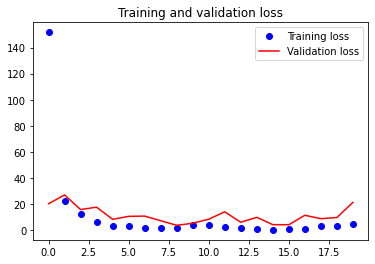

In [17]:
hist_loss = train_hist.history['loss']
hist_val_loss = train_hist.history['val_loss']
epoch_list = list(range(epochs))
plt.figure(1)
plt.plot(epoch_list, hist_loss, 'bo', label='Training loss')
plt.plot(epoch_list, hist_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Test on random vowel

In [18]:
rand_n = int(random.uniform(0, TF_data_test.shape[0]))
sample_data = TF_data_test[rand_n,:].reshape(1,TF_data_test.shape[1])
sample_label = TF_label_test[rand_n]

pred = model.predict(sample_data)
print(f'True       -> {sample_label}')
print(f'Prediction -> {vowels[np.argmax(pred)]}' )

True       -> E
Prediction -> E


## Plot functions

In [19]:
def plotTest(data, label, model, letters):
    
    correct = 0
    mistaken = 0
    
    label = lettToSoft(label, letters)

    total = data.shape[0]

    for i in range(0, data.shape[0]):
        pred = model.predict(data[i,:].reshape(1,data.shape[1]))

        if (np.argmax(pred) == np.argmax(label[i])):
            correct +=1
        else:
            mistaken +=1

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Test performance')

    langs = ['Correct', 'Error']
    langs.reverse
    bars = [correct,mistaken]
    bars.reverse
    ax.bar(langs,bars)
    plt.show()

    print(f"Total correct guesses {correct}  -> {round(correct/total,2)*100}%")
    print(f"Total mistaken guesses {mistaken} -> {round(mistaken/total,2)*100}%")

In [20]:
def testOL(model):

    corr_ary = np.zeros([8])
    err_ary = np.zeros([8])
    tot_ary = np.zeros([8])

    for j in range(0,4):

        if(j==0):
            data = OL_data_test_vow
            label = OL_label_test_vow
        elif(j==1):
            data = B_test_data
            label = B_test_label
        elif(j==2):
            data = R_test_data
            label = R_test_label
        elif(j==3):
            data = M_test_data
            label = M_test_label
        

        correct = 0
        mistaken = 0
        label_soft = lettToSoft(label,model.label)
        
        total = data.shape[0]

        for i in range(0, total):          
            ML_out = model.ML_frozen.predict(data[i,:].reshape(1,data.shape[1]))
            y_pred = model.predict(ML_out)

            # Find the max for borh the true label and the inference
            k = np.argmax(label_soft[i,:])
            

            max_i_true = -1
            max_i_pred = -1
            
            # Find the max iter for both true label and prediction
            if(np.amax(label_soft[i,:]) != 0):
                max_i_true = np.argmax(label_soft[i,:])
                
            if(np.amax(y_pred[0,:]) != 0):
                max_i_pred = np.argmax(y_pred[0,:])
                              
            if (max_i_pred == max_i_true):
                correct +=1
                if(j==0):
                    corr_ary[k] += 1
                    tot_ary[k] += 1  
            else:
                mistaken +=1
                if(j==0):
                    err_ary[k] += 1  
                    tot_ary[k] += 1  
                
        if(j!=0):
            corr_ary[4+j] = correct
            err_ary[4+j] = mistaken
            tot_ary[4+j] = total
        
    return corr_ary, err_ary, tot_ary

In [21]:
def testOL_v2(model):

    corr_ary = np.zeros([8])
    err_ary = np.zeros([8])
    tot_ary = np.zeros([8])

    for j in range(0,4):

        if(j==0):
            data = OL_data_test_vow
            label = OL_label_test_vow
        elif(j==1):
            data = B_train_data
            label = B_train_label
        elif(j==2):
            data = R_train_data
            label = R_train_label
        elif(j==3):
            data = M_train_data
            label = M_train_label

        correct = 0
        mistaken = 0
        label_soft = lettToSoft(label,['A', 'E', 'I', 'O', 'U', 'B', 'R', 'M'])

        total = data.shape[0]

        for i in range(0, data.shape[0]):          
            y_pred = model.predict(data[i,:].reshape(1,data.shape[1]))
            
            k = np.argmax(label_soft[i,:])      
            
            if (np.argmax(y_pred) == np.argmax(label_soft[i,:])):
                correct +=1
                if(j==0):
                    corr_ary[k] += 1
                    tot_ary[k] += 1
            else:
                mistaken +=1
                if(j==0):
                    err_ary[k] += 1
                    tot_ary[k] += 1

        if(j!=0):
            corr_ary[4+j] = correct
            err_ary[4+j] = mistaken
            tot_ary[4+j] = total
        
    return corr_ary, err_ary, tot_ary

In [22]:
def plotTestOL(corr_ary, err_ary, tot_ary, title, filename):
    
    corr_ary_2 = np.copy(corr_ary)
    err_ary_2 = np.copy(err_ary)
    
    for i in range(0, len(corr_ary)):
        corr_ary_2[i] = int(round(corr_ary[i]/tot_ary[i], 2)*100)
        err_ary_2[i] = int(round(err_ary[i]/tot_ary[i], 2)*100)
    
    width = 0.25
    fig = plt.subplots(figsize =(12, 8))
    
    # Set position of bar on X axis
    br1 = np.arange(len(corr_ary_2))
    br2 = [x + width for x in br1]
    
    # Make the plot
    plt.bar(br1, corr_ary_2, color ='g', width = width, edgecolor ='grey', label ='Correct prediction')
    plt.bar(br2, err_ary_2, color ='r', width = width, edgecolor ='grey', label ='Wrong prediction')

    # Adding Xticks
    plt.ylabel('%', fontweight ='bold', fontsize = 15)
    plt.xticks([r + width for r in range(len(corr_ary))], ['A', 'E', 'I', 'O', 'U', 'B', 'R', 'M'],fontweight ='bold', fontsize = 15)
    plt.title(title,fontweight ='bold', fontsize = 15)

    PLOT_PATH = 'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Plots/'
    plt.savefig(PLOT_PATH + filename + '.jpg')

In [23]:
def tableTestOL(corr_ary, err_ary, tot_ary, title):

    val = np.zeros([2,len(corr_ary)])
    val[0,:] = np.round(np.round(corr_ary/tot_ary,2)*100,2)
    val[1,:] = np.round(np.round(err_ary/tot_ary,2)*100,2)

    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    
    table = ax.table( 
        cellText = val,  
        rowLabels = ['Correct', 'Error'],  
        colLabels = ['A', 'E', 'I', 'O', 'U', 'B', 'R', 'M'], 
        rowColours =["palegreen"] * 200,  
        colColours =["palegreen"] * 200, 
        cellLoc ='center',  
        loc ='upper left')         

    ax.set_title(title, fontweight ="bold") 

    plt.show() 

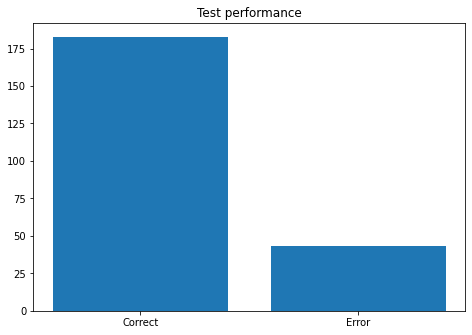

Total correct guesses 183  -> 81.0%
Total mistaken guesses 43 -> 19.0%


In [24]:
plotTest(TF_data_test, TF_label_test, model, vowels)

### Save model

In [25]:
def saveParams(SAVE_MODEL_PATH, model):
    
    new_file = open(SAVE_MODEL_PATH + '/params.txt', "w")

    new_file.write("PARAMETERS SAVED FROM THE TRAINING")
    new_file.write("\n Batch size: " + str(batch_size))
    new_file.write("\n Epochs: " + str(epochs))
    new_file.write("\n Validation split: " + str(0.2))
    new_file.write("\n Metrics: " + str(metrics))
    new_file.write("\n Optimizer: " + optimizer)
    new_file.write("\n Loss: " + loss + "\n\n")

    model.summary(print_fn=lambda x: new_file.write(x + '\n'))

In [26]:
SAVE_MODEL_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Saved_models/model/"
model.save(SAVE_MODEL_PATH + "model.h5")
saveParams(SAVE_MODEL_PATH, model)

#  ------------------------------------------------------------------------

# TinyOL

In [27]:
num_epochs = 1
learn_rate = 0.0003
lam = 0.4
batch_size_new = 16

### Functions

In [28]:
class Custom_Layer(object):
    def __init__(self, model):

        self.ML_frozen = keras.models.Sequential(model.layers[:-1])
        self.ML_frozen.compile()
        self.W = np.array(model.layers[-1].get_weights()[0])
        self.b = np.array(model.layers[-1].get_weights()[1])
        self.label = ['A', 'E', 'I', 'O', 'U']
        
        self.width = self.W.shape[0]

    def predict(self, x):
        mat_prod = np.matmul(x, self.W) + self.b
        return tf.nn.softmax(mat_prod)      

In [29]:
def checkNewClass(model, y_true, y_true_soft, i, gauss):
    
    # Check if letter is new
    found = 0
    for k in range(0, len(model.label)):
        if (y_true[i] == model.label[k]):
            found = 1

    # If first time seeing this letter
    if (found == 0):

        model.label.append(y_true[i])   # Add new letter to label
        print(f'\n\n    New letter detected -> letter \033[1m{y_true[i]}\033[0m \n')
    
        if(gauss==0):
            model.W = np.hstack((model.W, np.zeros([model.width,1])))
            model.b = np.hstack((model.b, np.zeros([1])))
        elif(gauss==1):
            gaussW = np.zeros([model.width,1])
            for i in range(0,model.width):
                gaussW[i,0] = random.gauss(0, 0.01)
            gaussB = random.gauss(0, 0.01)
            model.W = np.hstack((model.W, gaussW))
            model.b = np.hstack((model.b, gaussB))
        elif(gauss==2):  # sporcariaper far funzionare LWF
            model.W = np.hstack((model.W, np.zeros([model.width,1])))
            model.b = np.hstack((model.b, np.zeros([1])))
            
                   
        print(f'    Now W is -> {model.W.shape}              and b is -> {model.b.shape}\n\n')

        y_true_soft = lettToSoft(y_true, model.label)
                
    return y_true_soft

### OL

In [30]:
def trainOneEpoch_OL(model, x, y_true, learn_rate):
    
    print('**********************************\nPerforming training with OL METHOD - STOCHASTICH\n')
   
    cntr=1
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)  # Transform the true label letters in softmax
        
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        # PPREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])        
          
        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b = model.b-db
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

In [31]:
def trainOneEpoch_OL_miniBatch(model, x, y_true, learn_rate, batch_size):
    
    print('**********************************\nPerforming training with OL METHOD - MINI BATCH\n')
    
    cntr=1
    tot_samples = x.shape[0]
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
    
    y_true_soft = lettToSoft(y_true, model.label)     # Transform the true label letters in softmax array
        
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        if(i%batch_size==0):
                model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,:w]
                model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]

                sum_gradW = np.zeros([h, 8])  #reset each batch  
                sum_gradB = np.zeros([1, 8])  #reset each batch   
        
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,h): 
            # Update weights
            tmp = np.multiply(cost, y_ML[0,j]) 
            deltaW = np.zeros([1,8])
            deltaW[0,:w] = tmp  
            sum_gradW[j,:] += deltaW[0,:]

        # Update biases
        deltaB = np.zeros([1,8])
        deltaB[0,:w] = cost
        sum_gradB += deltaB

        # If last iteration
        if(i==tot_samples-1):
            model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,:w]
            model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### OL v2

In [32]:
  def trainOneEpoch_OL_v2(model, x, y_true, learn_rate):
    
    print('**********************************\nPerforming training with CWR METHOD - STOCASTICH \n')
    
    cntr=1
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax
            
    # Cycle over every sample
    for i in range(0, tot_samples):
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 1)    # Check if letter is new
        
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]  

        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,5:] = model.W[j,5:]-dW[5:]

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b[5:] = model.b[5:]-db[5:]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

In [33]:
def trainOneEpoch_OL_v2_miniBatch(model, x, y_true, learn_rate, batch_size):
    
    print('**********************************\nPerforming training with CWR - MINI BATCH \n ')  

    cntr=1
    tot_samples = x.shape[0]
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
    
    # Transform the true label letters in softmax array
    y_true_soft = lettToSoft(y_true, model.label)
           
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0) # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # If beginning of batch
        if(i%batch_size==0):
                model.W[:,5:] = model.W[:,5:] - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,5:w]
                model.b[5:]   = model.b[5:]   - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,5:w]
                sum_gradW = np.zeros([h, 8])  # reset
                sum_gradB = np.zeros([1, 8])  # reset
            
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,h):  
            # Update weights
            tmp = np.multiply(cost, y_ML[0,j]) 
            deltaW = np.zeros([1,8])
            deltaW[0,:tmp.shape[0]] = tmp  
            sum_gradW[j,:] += deltaW[0,:]

        # Update biases
        deltaB = np.zeros([1,8])
        deltaB[0,:cost.shape[0]] = cost
        sum_gradB += deltaB

        # If last iteration
        if(i==tot_samples-1):
            model.W[:,5:] = model.W[:,5:] - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,5:w]
            model.b[5:]   = model.b[5:]   - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,5:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### CWR

In [34]:
def trainOneEpoch_CWR(model, x, y_true, learn_rate, batch_size):
        
    print('**********************************\nPerforming training CWR \n ')  

    cntr=1
    tot_samples = x.shape[0]
    TW = np.zeros([model.W.shape[0], 8])
    TB = np.zeros([1, 8])
    found_lett = np.zeros([1,8])
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax array
           
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0) # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # If beginning of batch
        if(i%batch_size==0 and i!=0): 
            for k in range(5, w):
                if(found_lett[0,k]==0):
                    model.W[:,k] = TW[:,k]
                    model.b[k]   = TB[0,k]
                else:
                    tempW = np.multiply(model.W[:,k], found_lett[0,k])
                    tempB = np.multiply(model.b[k], found_lett[0,k])
                    model.W[:,k] = np.multiply(tempW+TW[:,k], 1/(found_lett[0,k]+1))
                    model.b[k]   = np.multiply(tempB+TB[0,k], 1/(found_lett[0,k]+1))
                
            TW = np.zeros([h, 8])        # reset
            TB = np.zeros([1, 8])        # reset
            found_lett = np.zeros([1,8]) # reset
        elif(i==0):
            TW = np.zeros([h, 8]) 
            TB = np.zeros([1, 8])        # reset
            for u in range(0,5):
                for p in range(0, h):
                    TW[p,u] = model.W[p,u]
                TB[0,u] = model.b[u]     
                
        found_lett[0,np.argmax(y_true_soft[i,:])] += 1
            
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = tf.nn.softmax(np.matmul(y_ML, TW) + TB)

        # BACKPROPAGATION
        cost = y_pred[0,:w]-y_true_soft[i,:]

        for j in range(0,h):  # da 0 a 300
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            TW[j,:w] = TW[j,:w] - dW

        # Update biase
        db = np.multiply(cost, learn_rate)
        TB[0,:w] = TB[0,:w]-db

        # If last iteration
        if(i==tot_samples-1):
            for k in range(5, w):
                if(found_lett[0,k]==0):
                    model.W[:,k] = TW[:,k]
                    model.b[k]   = TB[0,k]
                else:
                    tempW = np.multiply(model.W[:,k], found_lett[0,k])
                    tempB = np.multiply(model.b[k], found_lett[0,k])
                    model.W[:,k] = np.multiply(tempW+TW[:,k], 1/(found_lett[0,k]+1))
                    model.b[k]   = np.multiply(tempB+TB[0,k], 1/(found_lett[0,k]+1))
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1
        

### LWF

In [35]:
def trainOneEpochOL_LWF(model, x, y_true, learn_rate):
    
    print('**********************************')
    print('Performing training with OL METHOD - LWF')
    print()
    
    lam  = 0
    cntr = 1
    tot_samples = x.shape[0]
    y_LWF = np.zeros([tot_samples, 8])    # Define container for LWF

    # Perform nitial prediciton for LWF
    print('   Performing prediction of all dataset')
    for u in range(0, x.shape[0]):
        y_ML = model.ML_frozen.predict(x[u,:].reshape(1,x.shape[1]))
        y_LWF[u,:5] = model.predict(y_ML[0,:])
    
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax
         
    # Cycle over every sample
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 2)   # Check if letter is new
        
        w = model.W.shape[1]
        h = model.W.shape[0]
        if(w==6):
            lam = 2/3
        elif(w==7):
            lam = 3/4
        elif(w==8):
            lam = 4/5
            
             
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])
      
        
        # BACKPROPAGATION        
        cost_norm = y_pred-y_true_soft[i,:]
        cost_LWF  = y_pred-y_LWF[i,:w]

        for j in range(0,h):
            # Update weights
            deltaW_norm = np.multiply(cost_norm,1-lam)
            deltaW_LWF  = np.multiply(cost_LWF, lam)
            deltaW      = np.multiply(deltaW_norm+deltaW_LWF, y_ML[0,j])
            dW          = np.multiply(deltaW, learn_rate)

            model.W[j,:] = model.W[j,:]-dW

            # Update biases
            db_norm = np.multiply(cost_norm, 1-lam)
            db_LWF  = np.multiply(cost_LWF, lam)
            db      = np.multiply(db_norm+db_LWF, learn_rate)
            model.b = model.b-db
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

In [36]:
def trainOneEpochOL_LWF_v2(model, x, y_true, learn_rate, batch_size):
    
    print('**********************************\nPerforming training with OL METHOD - LWF with MINI BATCH\n')
    
    lam  = 0
    cntr = 1
    tot_samples = x.shape[0]
    # Transform the true label letters in softmax array
    y_true_soft = lettToSoft(y_true, model.label)
        
        
    # Initialize now and then reset it once every batch_size
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
    
    # Define a matrix that I can then fill with the initial inference
    y_LWF = np.zeros([ x.shape[0], 8])
    
    # For every sample in the dataset given
    for i in range(0, tot_samples):
        
        
        # Check if letter is new
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        if(w==6):
            lam = 2/3
        elif(w==7):
            lam = 3/4
        elif(w==8):
            lam = 4/5
        
        # Reset the matrices that keep track of the summation of gradient
        if(i%batch_size==0):
                model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h, :w]
                model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]
            
                sum_gradW = np.zeros([h, 8])
                sum_gradB = np.zeros([1, 8])
                
                # Value that avoids the last prediction of LWF to be outside of dataset dimension
                limit = 0
                if(i+batch_size > tot_samples):
                    limit = i+batch_size-tot_samples
                    
                
                for k in range(0, batch_size-limit):
                    # Prediction from ML frozen model
                    y_ML = model.ML_frozen.predict(x[i+k,:].reshape(1,x.shape[1]))
                    # Prediction from LWF 
                    y_LWF[k,:w] = model.predict(y_ML[0,:])
      
        # Prediction from ML frozen model
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        # Prediction from TinyOL layer
        y_pred = model.predict(y_ML[0,:])
         
        # ---- BACKPROPAGATION | MINI BATCH + LWF
        cost_norm = y_pred-y_true_soft[i,:]
        cost_LWF  = y_pred-y_LWF[i,:w]

        

        for j in range(0,h):  # da 0 a 300

            # Update weights
            tmp_norm     = np.multiply(cost_norm, 1-lam)
            tmp_LWF      = np.multiply(cost_LWF,  lam)
            if(len(tmp_LWF)>5):
                tmp_LWF[5] = 0
            elif(len(tmp_LWF)>6):
                tmp_LWF[6] = 0
            elif(len(tmp_LWF)>7):
                tmp_LWF[7] = 0
            tmp_tot      = np.multiply(tmp_norm+tmp_LWF, y_ML[0,j])
            deltaW       = deltaW = np.zeros([1,8])
            deltaW[0,:w] = tmp_tot 
            
            sum_gradW[j,:] += deltaW[0,:]            
            


            # Update biases
            db_norm = np.multiply(cost_norm, 1-lam)
            db_LWF  = np.multiply(cost_LWF,  lam)    
            deltaB = np.zeros([1,8])
            deltaB[0,:w] = db_norm+db_LWF
            
            sum_gradB += deltaB
            
        # if is last iteration , update the matrix
        if(i==tot_samples-1):
            model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h, :w]
            model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### Create ML model (cut model)

In [37]:
ML_model = keras.models.Sequential(model.layers[:-1])
ML_model.summary()
ML_model.compile()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 128)               76928     
_________________________________________________________________
hidden2 (Dense)              (None, 300)               38700     
Total params: 115,628
Trainable params: 115,628
Non-trainable params: 0
_________________________________________________________________


In [38]:
SAVE_MODEL_CUT_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Saved_models/Frozen_model/"
ML_model.save(SAVE_MODEL_CUT_PATH + "model.h5")
saveParams(SAVE_MODEL_CUT_PATH, ML_model)

# Trainings

### Train with OL only on vowels

In [519]:
Model_OL_vowels = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpoch_OL(Model_OL_vowels, OL_data_train_vow, OL_label_train_vow, learn_rate)

**********************************
Performing training with OL METHOD - STOCHASTICH

    Currently at 100.0% of dataset

### Train with LWF

In [520]:
Model_LWF_1 = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpochOL_LWF(Model_LWF_1, mixed_data_all, mixed_label_all, learn_rate)   

**********************************
Performing training with OL METHOD - LWF

   Performing prediction of all dataset
    Currently at 0.49% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.99% of dataset

    New letter detected -> letter M 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.73% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train LWF + mini batches

In [521]:
Model_LWF_2 = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpochOL_LWF_v2(Model_LWF_2, mixed_data_all, mixed_label_all, learn_rate, batch_size_new)

**********************************
Performing training with OL METHOD - LWF with MINI BATCH

    Currently at 0.49% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.99% of dataset

    New letter detected -> letter M 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.73% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL method

In [522]:
Model_OL_all_mixed = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpoch_OL(Model_OL_all_mixed, mixed_data_all, mixed_label_all, learn_rate)

**********************************
Performing training with OL METHOD - STOCHASTICH

    Currently at 0.49% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.99% of dataset

    New letter detected -> letter M 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.73% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL + mini batch

In [523]:
Model_OL_mini = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpoch_OL_miniBatch(Model_OL_mini, mixed_data_all, mixed_label_all, learn_rate, batch_size_new)

**********************************
Performing training with OL METHOD - MINI BATCH

    Currently at 0.49% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.99% of dataset

    New letter detected -> letter M 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.73% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL v2 

In [524]:
Model_OL_v2 = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpoch_OL_v2(Model_OL_v2, mixed_data_all, mixed_label_all, learn_rate)

**********************************
Performing training with CWR METHOD - STOCASTICH 

    Currently at 0.49% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.99% of dataset

    New letter detected -> letter M 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.73% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL v2 + mini batch

In [525]:
Model_OL_v2_miniBatch = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpoch_OL_v2_miniBatch(Model_OL_v2_miniBatch, mixed_data_all, mixed_label_all, learn_rate, batch_size_new)

**********************************
Performing training with CWR - MINI BATCH 
 
    Currently at 0.49% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.99% of dataset

    New letter detected -> letter M 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.73% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with CWR

In [526]:
Model_CWR = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpoch_CWR(Model_CWR, mixed_data_all, mixed_label_all, learn_rate, batch_size_new)

**********************************
Performing training CWR 
 
    Currently at 0.49% of dataset

    New letter detected -> letter B 

    Now W is -> (300, 6)              and b is -> (6,)


    Currently at 0.99% of dataset

    New letter detected -> letter M 

    Now W is -> (300, 7)              and b is -> (7,)


    Currently at 1.73% of dataset

    New letter detected -> letter R 

    Now W is -> (300, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

# PLOTS

### Original model

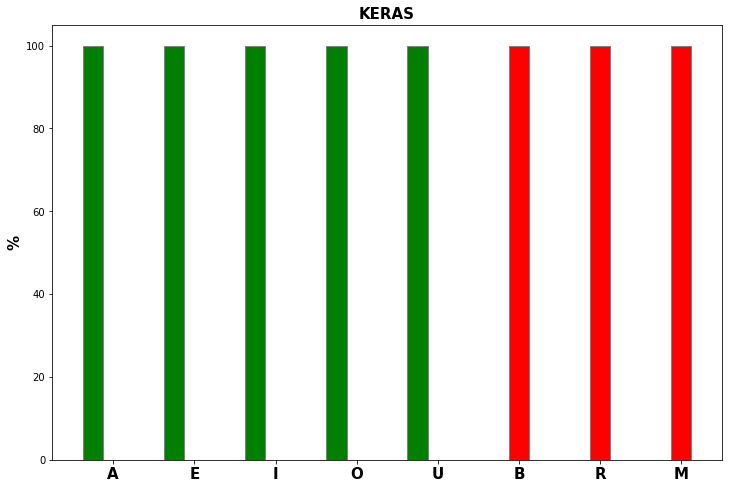

In [527]:
res00, res01, res02 = testOL_v2(model)
plotTestOL(res00, res01, res02, 'KERAS', 'origModel')

### Only vowels

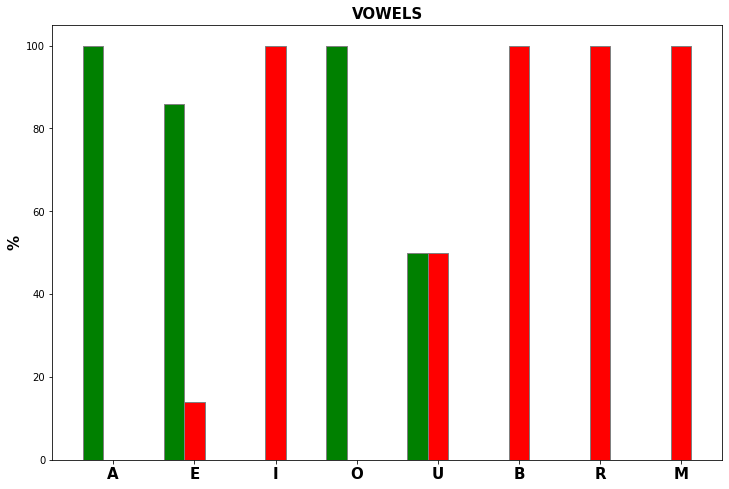

In [528]:
res10, res11, res12 = testOL(Model_OL_vowels)
plotTestOL(res10, res11, res12, 'VOWELS', 'trainVowels')

### OL

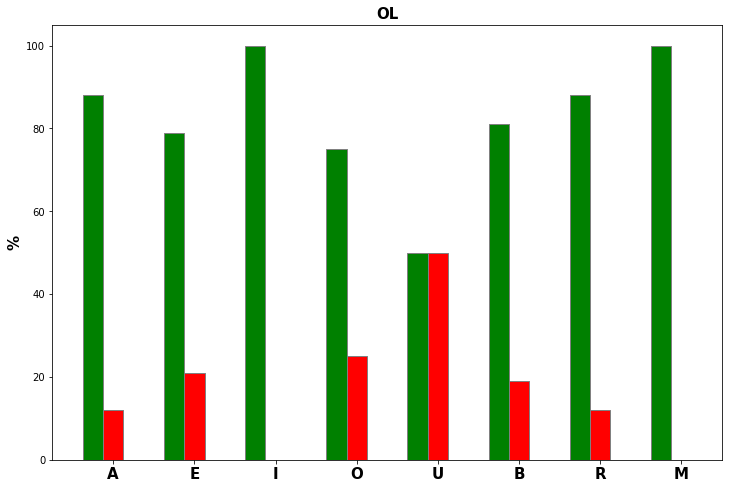

In [529]:
res20, res21, res22 = testOL(Model_OL_all_mixed)
plotTestOL(res20, res21, res22, 'OL', 'trainOL')

### OL + mini batch

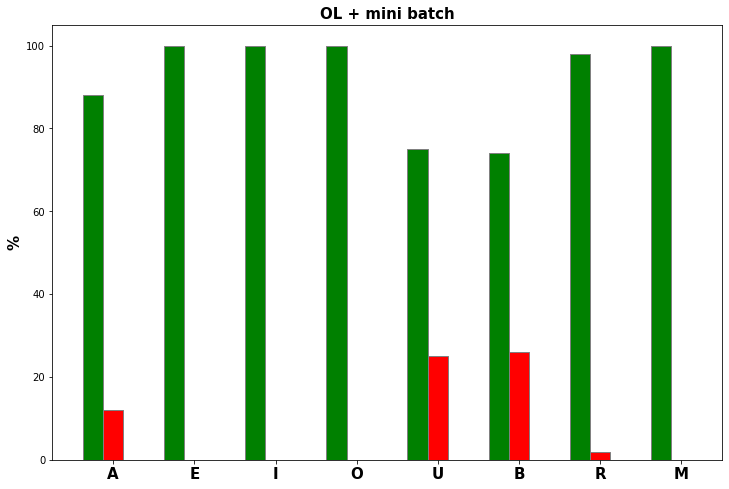

In [530]:
res30, res31, res32 = testOL(Model_OL_mini)
plotTestOL(res30, res31, res32, 'OL + mini batch', 'trainOL_mini')

### LWF

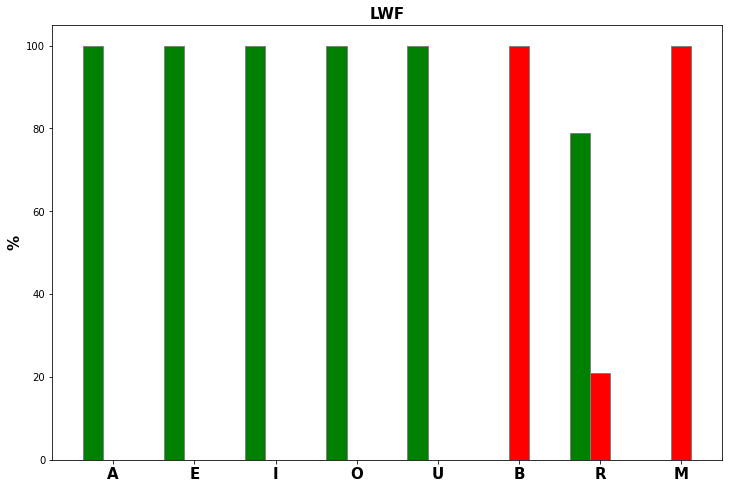

In [531]:
res40, res41, res42 = testOL(Model_LWF_1)
plotTestOL(res40, res41, res42, 'LWF', 'trainLWF_v1')

### LWF + mini batch

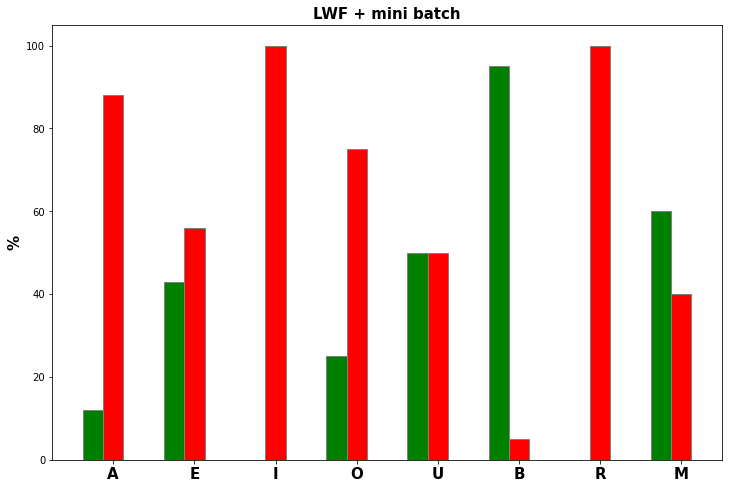

In [532]:
res50, res51, res52 = testOL(Model_LWF_2)
plotTestOL(res50, res51, res52, 'LWF + mini batch', 'trainLWF_v2')

### OL v2

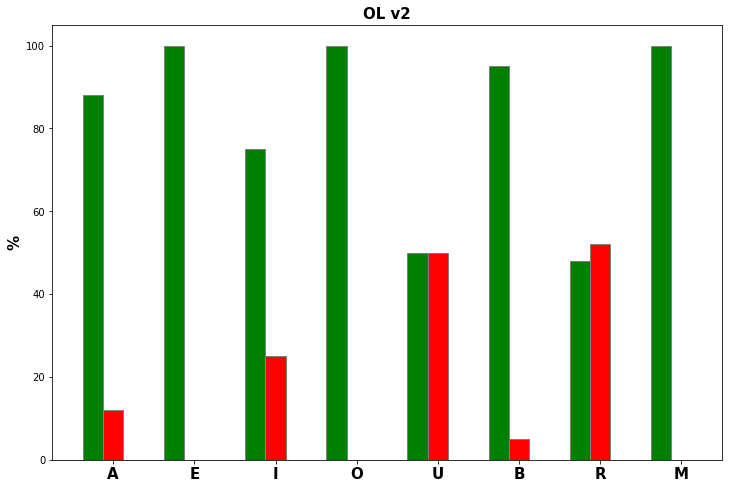

In [533]:
res60, res61, res62 = testOL(Model_OL_v2)
plotTestOL(res60, res61, res62, 'OL v2', 'trainOL_v2')

### OL v2 + mini batch

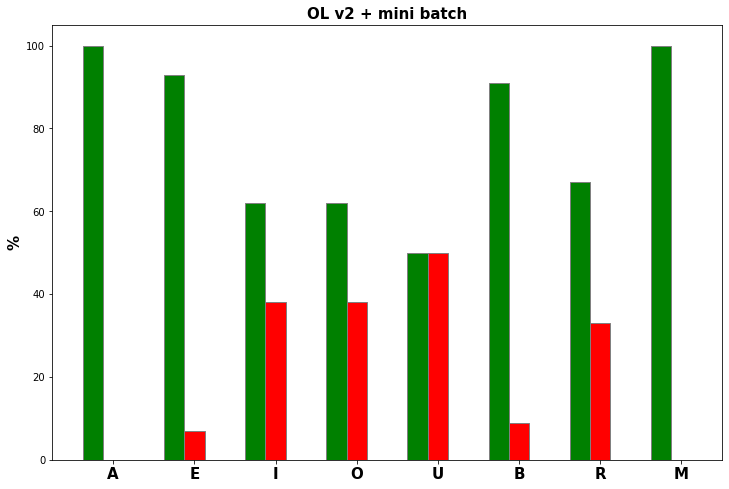

In [534]:
res70, res71, res72 = testOL(Model_OL_v2_miniBatch)
plotTestOL(res70, res71, res72, 'OL v2 + mini batch', 'trainOL_v2_mini')

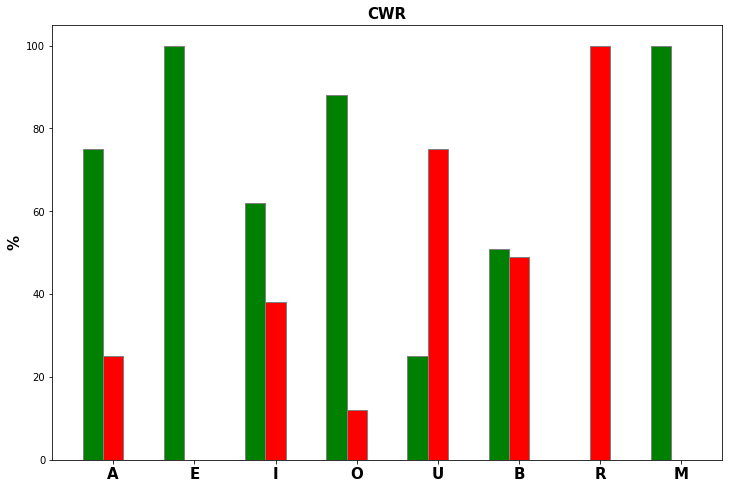

In [535]:
res80, res81, res82 = testOL(Model_CWR)
plotTestOL(res80, res81, res82, 'CWR', 'trainCWR')


## All plots

(-0.5, 863.5, 575.5, -0.5)

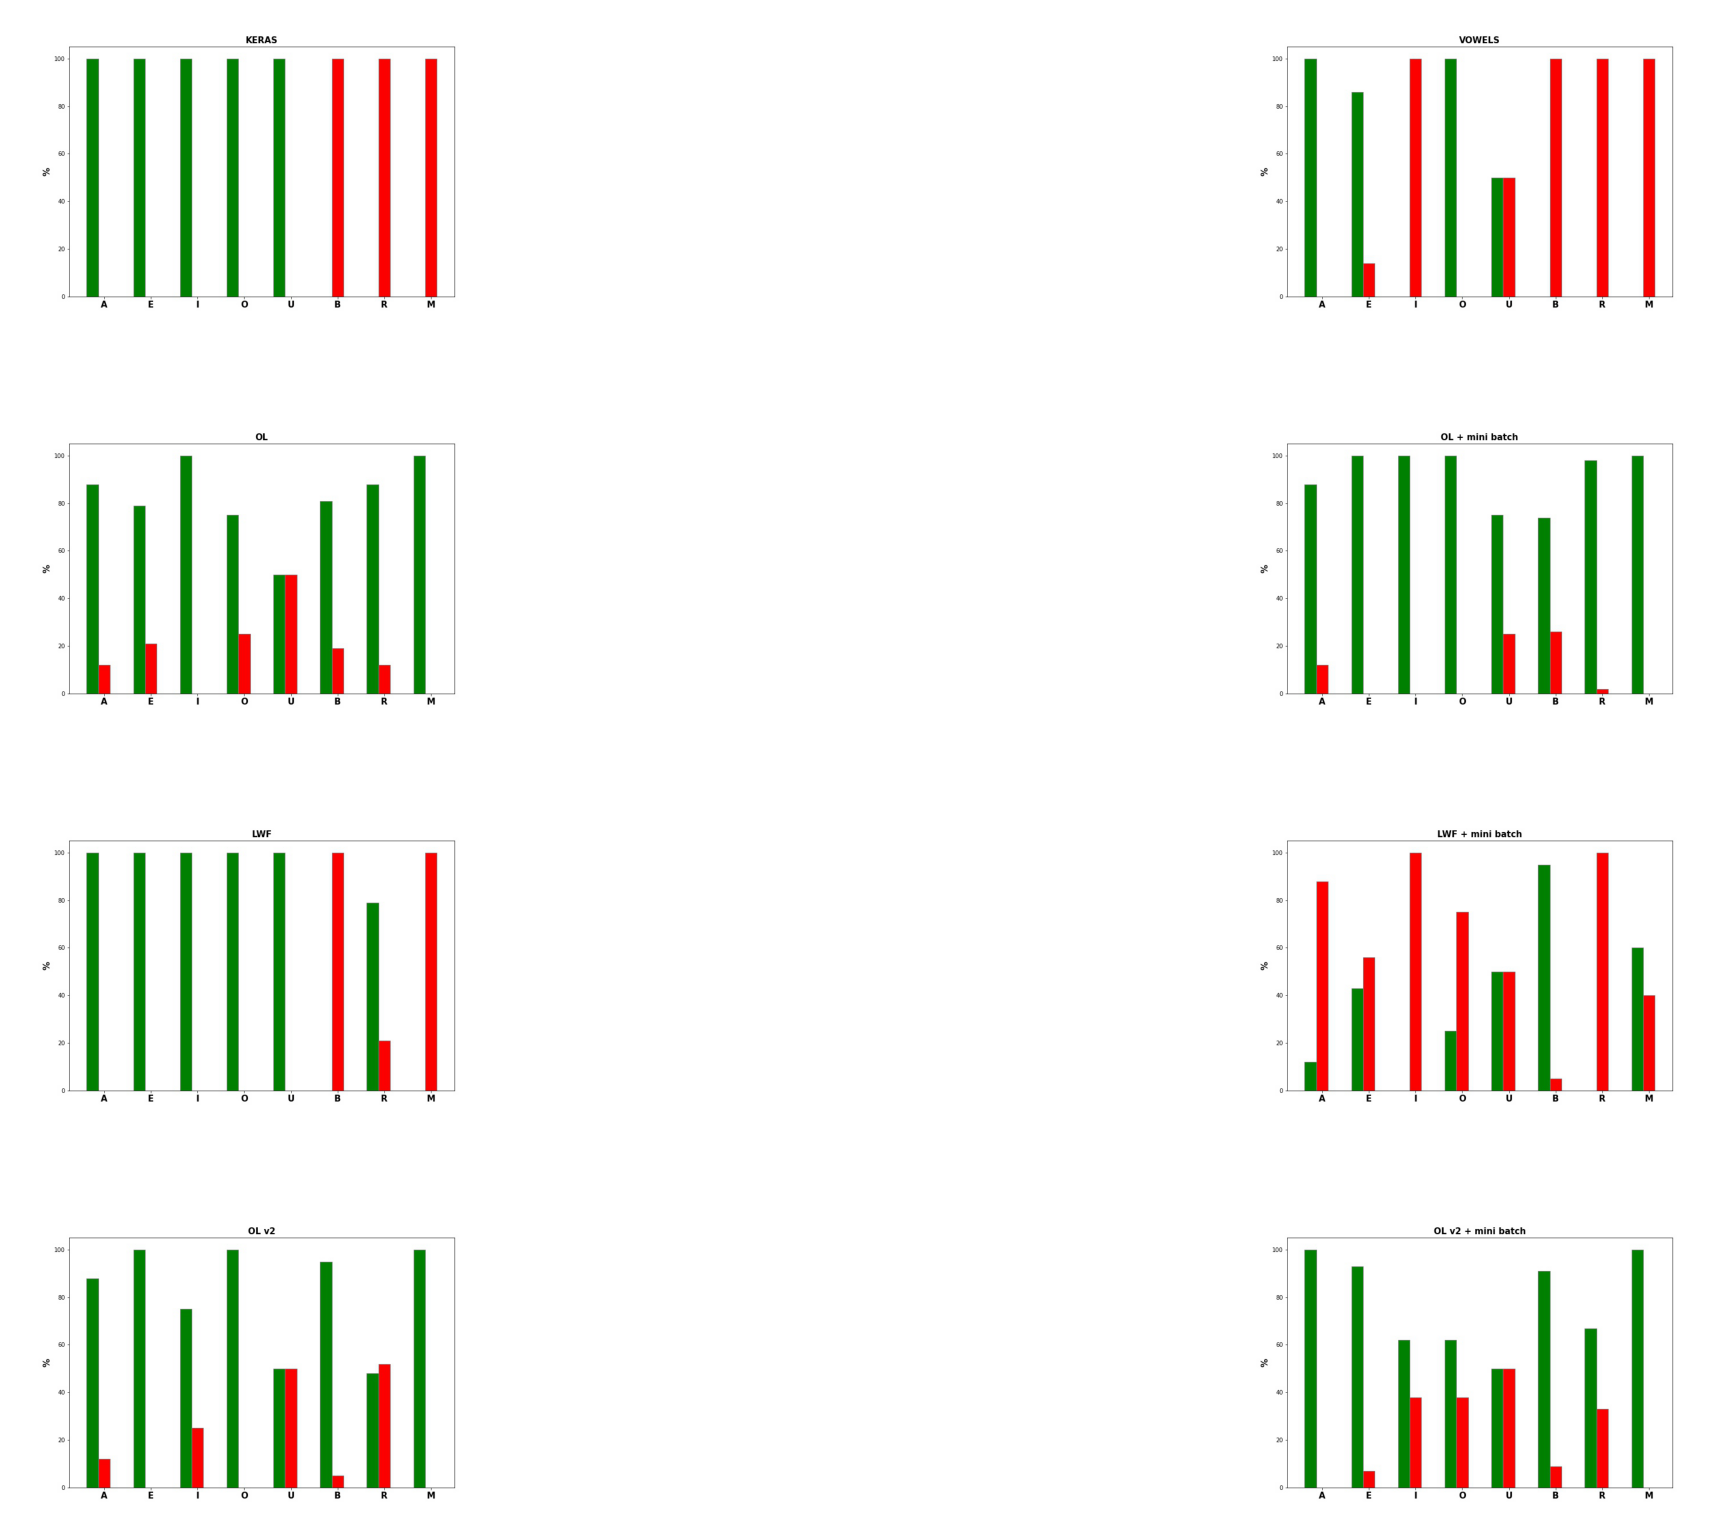

In [536]:
rows = 4
columns = 2
# create figure
fig = plt.figure(figsize=(40,28))
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
Image1 = mpimg.imread(r'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Plots/origModel.jpg')
Image2 = mpimg.imread(r'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Plots/trainVowels.jpg')
Image3 = mpimg.imread(r'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Plots/trainOL.jpg')
Image4 = mpimg.imread(r'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Plots/trainOL_mini.jpg')
Image5 = mpimg.imread(r'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Plots/trainLWF_v1.jpg')
Image6 = mpimg.imread(r'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Plots/trainLWF_v2.jpg')
Image7 = mpimg.imread(r'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Plots/trainOL_v2.jpg')
Image8 = mpimg.imread(r'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Plots/trainOL_v2_mini.jpg')
    
# showing image
plt.imshow(Image1)
plt.axis('off')
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(Image5)
plt.axis('off')

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(Image6)
plt.axis('off')

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(Image7)
plt.axis('off')

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(Image8)
plt.axis('off')

In [537]:
print('The best trained model is:')

print(res00)
print(res01)
print(res02)

print(f'ORIG:       {round(np.sum(res00)/np.sum(res02),4)*100}')
print(f'VOWELS:     {round(np.sum(res10)/np.sum(res12),4)*100}')
print(f'OL:         {round(np.sum(res20)/np.sum(res22),4)*100}')
print(f'OL + mini:  {round(np.sum(res30)/np.sum(res32),4)*100}')
print(f'LWF:        {round(np.sum(res40)/np.sum(res42),4)*100}')
print(f'LWF + mini: {round(np.sum(res50)/np.sum(res52),4)*100}')
print(f'OL v2:        {round(np.sum(res60)/np.sum(res62),4)*100}')
print(f'OL v2 + mini: {round(np.sum(res70)/np.sum(res72),4)*100}')
    

The best trained model is:
[ 8. 14.  8.  8.  4.  0.  0.  0.]
[  0.   0.   0.   0.   0. 102. 101. 101.]
[  8.  14.   8.   8.   4. 102. 101. 101.]
ORIG:       12.139999999999999
VOWELS:     17.75
OL:         87.57000000000001
OL + mini:  91.72
LWF:        44.379999999999995
LWF + mini: 45.56
OL v2:        82.84
OL v2 + mini: 84.02


In [39]:
# Write down in txt files all the results across 10 or so simulations

def writeSimuRes(filename, res1, res2, res3):
    
    ROOT_TXT_PATH = 'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/SimuRes/'
    
    with open(ROOT_TXT_PATH + filename +'.txt',"a") as f:
        for i in range(0, len(res1)):
            f.write(str(int(res1[i])))
            if(i==len(res1)-1):
                f.write('\n')
            else:
                f.write(',')
                
        for i in range(0, len(res2)):
            f.write(str(int(res2[i])))
            if(i==len(res2)-1):
                f.write('\n')
            else:
                f.write(',')
                
        for i in range(0, len(res3)):
            f.write(str(int(res3[i])))
            if(i==len(res3)-1):
                f.write('\n')
            else:
                f.write(',')
                

writeSimuRes('orig',      res00, res01, res02)
writeSimuRes('vowels',    res10, res11, res12)
writeSimuRes('OL',        res20, res21, res22)
writeSimuRes('OL_mini',   res30, res31, res32)
writeSimuRes('LWF',       res40, res41, res42)
writeSimuRes('LWF_mini',  res50, res51, res52)
writeSimuRes('OL_v2',     res60, res61, res62)
writeSimuRes('OL_v2_min', res70, res71, res72)
writeSimuRes('CWR',       res80, res81, res82)

NameError: name 'res00' is not defined

In [ ]:
def analyzeSimuRes(filename):

    ROOT_TXT_PATH = 'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/SimuRes/'
    
    data = np.loadtxt(ROOT_TXT_PATH + filename +'.txt', delimiter=',')

    for i in range(0, int(data.shape[0]/3)):
        k=i*3
        accuracy[i] = np.sum(data[k,:]) / np.sum(data[k+2,:])

    avrg_accuracy = round(np.sum(accuracy)/len(accuracy),2)

    print(f'Average accuracy for {filename} is: {avrg_accuracy}')
        

Average accuracy for orig is: 11.18
Average accuracy for vowels is: 16.57
Average accuracy for OL is: 73.55
Average accuracy for OL_mini is: 74.79
Average accuracy for LWF is: 27.28
Average accuracy for LWF_mini is: 38.22
Average accuracy for OL_v2 is: 75.74
Average accuracy for OL_v2_min is: 74.02
Average accuracy for CWR is: 52.9


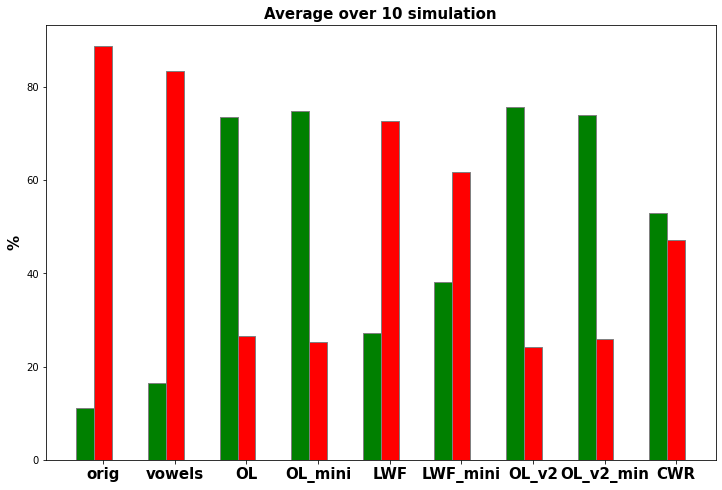

In [64]:
def plotSimuREs(plotEnable):
    
    ROOT_TXT_PATH = 'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/SimuRes/'
    
    names_ary = ['orig', 'vowels', 'OL', 'OL_mini', 'LWF', 'LWF_mini', 'OL_v2', 'OL_v2_min', 'CWR']
    
    avrg_accuracy = np.zeros(len(names_ary))
    avrg_err = np.zeros(len(names_ary))

    count = 0
    for filename in names_ary:
        
        data = np.loadtxt(ROOT_TXT_PATH + filename +'.txt', delimiter=',')

        for i in range(0, int(data.shape[0]/3)):
            k=i*3
            accuracy[i] = np.sum(data[k,:]) / np.sum(data[k+2,:])

        avrg_accuracy[count] = round(round(np.sum(accuracy)/len(accuracy),4)*100,2)
        avrg_err[count] = 100-avrg_accuracy[count]


        print(f'Average accuracy for {filename} is: {avrg_accuracy[count]}')
        count+=1
        
    if(plotEnable==1):

        width = 0.25
        fig = plt.subplots(figsize =(12, 8))

        # Set position of bar on X axis
        br1 = np.arange(len(avrg_accuracy))
        br2 = [x + width for x in br1]

        # Make the plot
        plt.bar(br1, avrg_accuracy, color ='g', width = width, edgecolor ='grey', label ='Correct prediction')
        plt.bar(br2, avrg_err, color ='r', width = width, edgecolor ='grey', label ='Wrong prediction')

        # Adding Xticks
        plt.ylabel('%', fontweight ='bold', fontsize = 15)
        plt.xticks([r + width for r in range(len(avrg_accuracy))], ['orig', 'vowels', 'OL', 'OL_mini', 'LWF', 'LWF_mini', 'OL_v2', 'OL_v2_min', 'CWR'],fontweight ='bold', fontsize = 15)
        plt.title('Average over 10 simulation',fontweight ='bold', fontsize = 15)

        #PLOT_PATH = 'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Plots/'
        #plt.savefig(PLOT_PATH + filename + '.jpg')


plotSimuREs(1)

In [56]:
analyzeSimuRes('orig')
analyzeSimuRes('vowels')
analyzeSimuRes('OL')
analyzeSimuRes('OL_mini')
analyzeSimuRes('LWF')
analyzeSimuRes('LWF_mini')
analyzeSimuRes('OL_v2')
analyzeSimuRes('OL_v2_min')
analyzeSimuRes('CWR')

Average accuracy for orig is: 0.11
Average accuracy for vowels is: 0.17
Average accuracy for OL is: 0.74
Average accuracy for OL_mini is: 0.75
Average accuracy for LWF is: 0.27
Average accuracy for LWF_mini is: 0.38
Average accuracy for OL_v2 is: 0.76
Average accuracy for OL_v2_min is: 0.74
Average accuracy for CWR is: 0.53















### ----------------------------------------------------------------------------------------------------------

# Scripts for generating libraries for the STM code

In [539]:
# WRITE THE VOWELS ON A TXT FILE

SAMPLE_LETTER_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Other/"

new_file = open(SAMPLE_LETTER_PATH + '/sample_input.h', "w")

sample_A = vowels_test_data[1,:]
sample_E = vowels_test_data[9,:]
sample_I = vowels_test_data[4,:]
sample_O = vowels_test_data[0,:]
sample_U = vowels_test_data[3,:]

new_file.write("#include \"main.h\" \n\n\n")


new_file.write('int sample_A[600] = {')
for j in range(0, 600):
        new_file.write(str(int(sample_A[j])))
        
        if(j!=599):
            new_file.write(',')
        if((j%20==0) and (j!=0)):
            new_file.write('\n                     ')
new_file.write('};')

new_file.write('\n\n\n')

new_file.write('int sample_E[600] = {')
for j in range(0, 600):
        new_file.write(str(int(sample_E[j])))
        
        if(j!=599):
            new_file.write(',')
        if((j%20==0) and (j!=0)):
            new_file.write('\n                     ')
new_file.write('};')

new_file.write('\n\n\n')

new_file.write('int sample_I[600] = {')
for j in range(0, 600):
        new_file.write(str(int(sample_I[j])))
        
        if(j!=599):
            new_file.write(',')
        if((j%20==0) and (j!=0)):
            new_file.write('\n                     ')
new_file.write('};')

new_file.write('\n\n\n')

new_file.write('int sample_O[600] = {')
for j in range(0, 600):
        new_file.write(str(int(sample_O[j])))
        
        if(j!=599):
            new_file.write(',')
        if((j%20==0) and (j!=0)):
            new_file.write('\n                     ')
new_file.write('};')

new_file.write('\n\n\n')

new_file.write('int sample_U[600] = {')
for j in range(0, 600):
        new_file.write(str(int(sample_U[j])))
        
        if(j!=599):
            new_file.write(',')
        if((j%20==0) and (j!=0)):
            new_file.write('\n                     ')
new_file.write('};')


NameError: name 'vowels_test_data' is not defined

In [ ]:
# WRITE THE LETTER B

SAMPLE_B_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Other/"

new_file = open(SAMPLE_B_PATH + '/letter_B.h', "w")



new_file.write("#include \"main.h\" \n\n\n")


new_file.write('int sample_B['+str(B_train_data.shape[0])+'][600] = {')
for i in range(0, B_train_data.shape[0]):
    new_file.write('\n          {')
    for j in range(0, 600):
            new_file.write(str(int(B_train_data[i,j])))
            if(j!=599):
                new_file.write(',')
            

    new_file.write('},')



In [ ]:
# WRITE A MIX OF LETTERS IN A TXT FILE

SAMPLE_LETTERS_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Other/"

new_file = open(SAMPLE_LETTERS_PATH + '/letters.h', "w")

mix_of_letters = B_train_data[:12,:]
mix_of_letters = np.vstack(( mix_of_letters, vowels_test_data[:12,:]))

mix_of_labels = B_train_label[:12]
mix_of_labels = np.hstack(( mix_of_labels, vowels_test_label[:12]))

new_file.write("#include \"main.h\" \n\n\n")


new_file.write('int rand_letters['+str(mix_of_letters.shape[0])+'][600] = {')
for i in range(0, mix_of_letters.shape[0]):
    new_file.write('\n          {')
    for j in range(0, 600):
            new_file.write(str(int(mix_of_letters[i,j])))
            if(j!=599):
                new_file.write(',')
            
    if(i!=mix_of_letters.shape[0]-1):
        new_file.write('},')
    else:
        new_file.write('} };')
        
        
        
new_file.write('\n\n\n')
new_file.write('char rand_labels['+str(mix_of_labels.shape[0])+'] = {')
for i in range(0, mix_of_labels.shape[0]):
    
    new_file.write('\''+str(mix_of_labels[i])+'\'')
            
    if(i!=mix_of_labels.shape[0]-1):
        new_file.write(',')
    else:
        new_file.write('};')


In [ ]:
# SAVE LAST LAYER OF MODEL IN .H FILE

LAST_LAYER_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Saved_models/Frozen_model/"

new_file = open(LAST_LAYER_PATH + '/layer_weights.h', "w")

weights = np.array(model.layers[-1].get_weights()[0])
biases  = np.array(model.layers[-1].get_weights()[1])



new_file.write('float saved_weights['+str(weights.shape[0]*weights.shape[1])+'] = {')

for j in range(0, weights.shape[1]):
    new_file.write('\n                       ')
    
    for i in range(0, weights.shape[0]):     
        new_file.write(str(weights[i,j])+',')
        if(i%32==0 and i!=0):
            new_file.write('\n                       ')
            
new_file.write('}; \n\n\n\n')



new_file.write('float saved_biases['+str(biases.shape[0])+'] = {')
    
for i in range(0, biases.shape[0]):     
    new_file.write(str(biases[i]))   
    if(i != biases.shape[0]-1):
        new_file.write(',')
new_file.write('};')
